# First, define a class called DataReader to read the data and extra the features

In my project, I have not use the spatial features (I only use the hog features and histogram features), after experiments.

In [1]:
from __future__ import print_function
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from feature_helper import *
from sklearn.model_selection import train_test_split


class DataReader(object):
    def __init__(self, car_root_path, no_car_root_path):
        self.car_path_list = self.read_file_list(car_root_path)
        self.noncar_path_list = self.read_file_list(no_car_root_path)

        car_features, notcar_features = self.get_features()

        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        self.scaled_X = self.X_scaler.transform(X)

        # Define the labels vector
        self.y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.scaled_X, self.y, test_size=0.2,
                                                                                random_state=rand_state)

        print('the shape of the X_train are', self.X_train.shape)
        print('number of test samples is', len(self.y_test), np.sum(self.y_test), 'car samples and ',
              len(self.y_test) - np.sum(self.y_test), 'noncar samples')

    def read_file_list(self, path):
        file_list = glob.glob(path+'/*/*.png')
        return file_list

    def get_features(self):
        color_space = 'YUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        orient = 12  # HOG orientations
        pix_per_cell = 16  # HOG pixels per cell
        cell_per_block = 2  # HOG cells per block
        hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
        spatial_size = (32, 32)  # Spatial binning dimensions
        hist_bins = 64  # Number of histogram bins
        spatial_feat = False  # Spatial features on or off
        hist_feat = True  # Histogram features on or off
        hog_feat = True  # HOG features on or off

        print('Using:', orient, 'orientations', pix_per_cell,
              'pixels per cell and', cell_per_block, 'cells per block')

        car_features = extract_features(self.car_path_list, color_space=color_space,
                                        spatial_size=spatial_size, hist_bins=hist_bins,
                                        orient=orient, pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                                        hist_feat=hist_feat, hog_feat=hog_feat)
        notcar_features = extract_features(self.noncar_path_list, color_space=color_space,
                                           spatial_size=spatial_size, hist_bins=hist_bins,
                                           orient=orient, pix_per_cell=pix_per_cell,
                                           cell_per_block=cell_per_block,
                                           hog_channel=hog_channel, spatial_feat=spatial_feat,
                                           hist_feat=hist_feat, hog_feat=hog_feat)

        return car_features, notcar_features

# define a svc classifier which used rbf kernel and c=1.0

In [2]:
def model(X_train, y_train, X_test, y_test):
    # Check the training time for the SVC
    t = time.time()
    clf = svm.SVC()
    # parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
    # svc = svm.SVC()
    # clf = GridSearchCV(svc, parameters)
    clf.fit(X_train, y_train)

    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
    return clf

# Train the model and save it as a pickle file

In [3]:
data = DataReader('vehicles', 'non-vehicles')

clf = model(data.X_train, data.y_train, data.X_test, data.y_test)

# save the svc Model and Scaler
with open('svc.pickle', 'wb') as f:
    disk_pickle = {}
    disk_pickle['clf'] = clf
    disk_pickle['X_scaler'] = data.X_scaler
    pickle.dump(disk_pickle, f)

Using: 12 orientations 16 pixels per cell and 2 cells per block


/usr/local/lib/python2.7/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


the shape of the X_train are (14208, 1488)
number of test samples is 3552 1741.0 car samples and  1811.0 noncar samples
31.69 Seconds to train SVC...
Test Accuracy of SVC =  0.9949


In [4]:
from scipy.ndimage.measurements import label
from feature_helper import *

# Reuse the find_cars function in the lesson

In [5]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
              cell_per_block, hist_bins, conv):

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv=conv)

    # rescale the
    ctrans_tosearch = ctrans_tosearch.astype(np.float32) / 255.

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    box_list = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()

            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            # spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)


            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return box_list

# Heatmap and search in a frame

In [6]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap  # Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255, 0, 0), 6)
    # Return the image
    return img


def process_frame(img, clf, X_scaler):
    rectangles = []
    draw_img = np.copy(img)

    conv = 'BGR2YUV'
    orient = 12  # HOG orientations
    pix_per_cell = 16  # HOG pixels per cell
    cell_per_block = 2  # HOG cells per block
    hist_bins = 64  # Number of histogram bins

    y_start_stop = [(400, 464), (416, 480), (400, 496), (432, 528), (400, 528), (432, 560), (400, 596), (464, 660)]
    scale = [1.0, 1.0, 1.5, 1.5, 2.0, 2.0, 3.5, 3.5]

    for i in range(4):
        rectangles.append(find_cars(img, y_start_stop[i][0], y_start_stop[i][1], scale[i], clf, X_scaler,
                                    orient, pix_per_cell, cell_per_block, hist_bins, conv))

    rectangles = [item for sublist in rectangles for item in sublist]

    heatmap_img = np.zeros_like(img[:, :, 0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)

    labels = label(heatmap_img)

    draw_img = draw_labeled_bboxes(draw_img, labels)
    return draw_img, heatmap_img

# Test the model on the test images, save the test images to the `output_images` folder

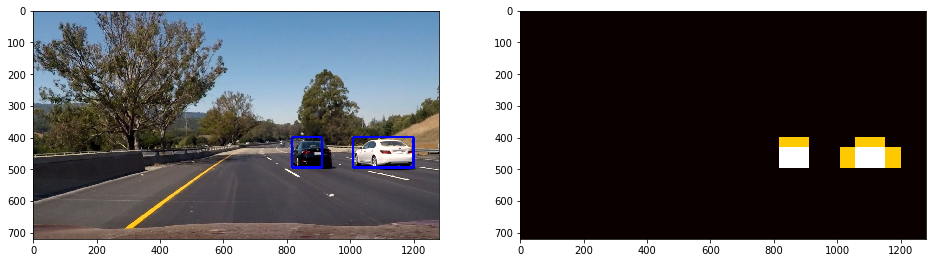

In [8]:
# load the Model
with open('svc.pickle', 'rb') as f:
    disk_pickle = pickle.load(f)
    clf = disk_pickle['clf']
    X_scaler = disk_pickle['X_scaler']
test_img_paths = glob.glob('test_images/*.jpg')

for item in test_img_paths:
    img = cv2.imread(item)
    out_img, heatmap_img = process_frame(img, clf, X_scaler)
    file_name = item.split('/')[1]
    cv2.imwrite('output_images/'+file_name, out_img)
# show one picture
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
plt.imshow(out_img)
plt.subplot(1, 2, 2)

plt.imshow(heatmap_img, cmap='hot')
plt.show()